,MAE,RMSE,R2,CV_R2_mean,CV_R2_std,Artifact
Model,,,,,,
ElasticNet,0.123393,1.018385,0.994747,0.997138,0.003111,artifacts_regression\ElasticNet.joblib
RandomForestRegressor,0.155050,1.064341,0.994262,0.994827,0.002849,artifacts_regression\RandomForestRegressor.joblib
GradientBoostingRegressor,0.156121,1.071270,0.994187,0.994387,0.003048,artifacts_regression\GradientBoostingRegressor...


Saved comparison table → artifacts_regression\regression_results_table.csv


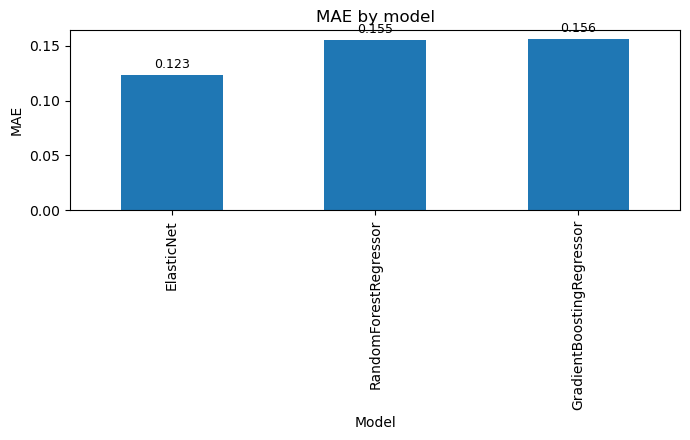

Saved plot → artifacts_regression\MAE_bar.png


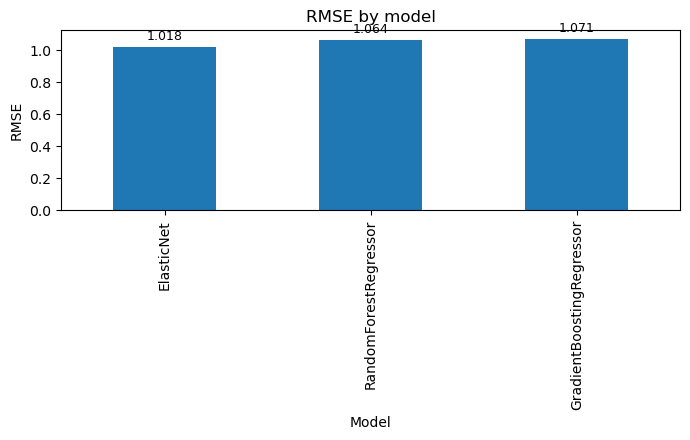

Saved plot → artifacts_regression\RMSE_bar.png


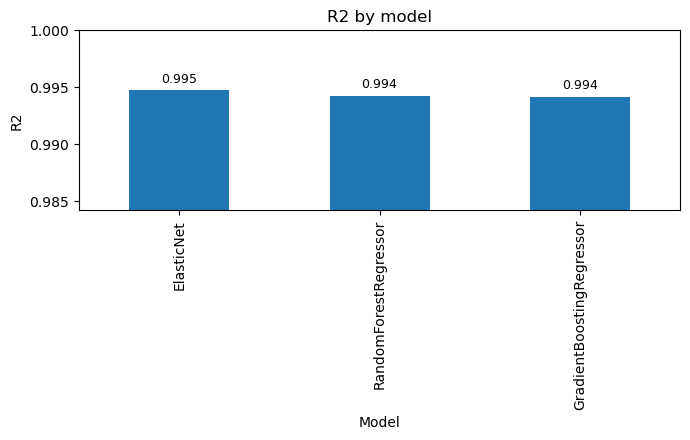

Saved plot → artifacts_regression\R2_bar.png


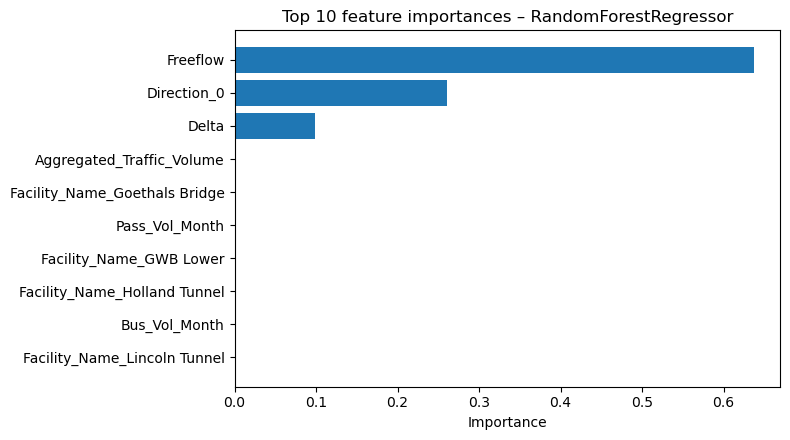

Saved plot → artifacts_regression\RandomForestRegressor_top10_importances.png

Model 1 – Regression: Traffic Speed Prediction

• Best model (by RMSE): ElasticNet
  - MAE = 0.123, RMSE = 1.018, R² = 0.994747
  - CV R² (mean ± std) = 0.997138 ± 0.003111

• Target (dependent): Avg_Speed
• Features (independent): Freeflow, Aggregated_Traffic_Volume, Delta, Facility_Name, Direction, (optional: Bus_Vol_Month, Pass_Vol_Month).

• Interpretation: The regression models achieve very high explanatory power (R² ≈ 0.995), indicating that average traffic speed can be predicted accurately from capacity (Freeflow), demand (Aggregated_Traffic_Volume), and congestion signals (Delta).

• Files saved:
  - Table (CSV): artifacts_regression\regression_results_table.csv
  - Plots: MAE_bar.png, RMSE_bar.png, R2_bar.png (in artifacts_regression)

Saved summary → artifacts_regression\regression_report_summary.txt


In [1]:
import os, json, math, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ARTI_DIR = "artifacts_regression"
os.makedirs(ARTI_DIR, exist_ok=True)

# -------- 1) Load metrics from summary.json --------
with open(os.path.join(ARTI_DIR, "summary.json"), "r") as f:
    res = json.load(f)

# Build a tidy comparison table
rows = []
for model, info in res.items():
    m = info["metrics"]
    rows.append({
        "Model": model,
        "MAE": m.get("MAE", np.nan),
        "RMSE": m.get("RMSE", np.nan),
        "R2": m.get("R2", np.nan),
        "CV_R2_mean": m.get("CV_R2_mean", np.nan),
        "CV_R2_std": m.get("CV_R2_std", np.nan),
        "Artifact": info.get("artifact", "")
    })
results_df = pd.DataFrame(rows).set_index("Model").sort_values("RMSE")
display(results_df)

# Save as appendix table
results_csv_path = os.path.join(ARTI_DIR, "regression_results_table.csv")
results_df.to_csv(results_csv_path)
print(f"Saved comparison table → {results_csv_path}")

# Identify best model by RMSE
best_model_name = results_df.index[0]
best_row = results_df.iloc[0].to_dict()

# -------- 2) Plots (matplotlib only) --------
def bar_plot(metric_name, ylim=None):
    plt.figure(figsize=(7, 4.5))
    vals = results_df[metric_name]
    ax = vals.plot(kind="bar")
    ax.set_title(f"{metric_name} by model")
    ax.set_ylabel(metric_name)
    ax.set_xlabel("Model")
    if ylim is not None: ax.set_ylim(*ylim)
    # add labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=9, rotation=0, xytext=(0,3), textcoords="offset points")
    plt.tight_layout()
    out = os.path.join(ARTI_DIR, f"{metric_name}_bar.png")
    plt.savefig(out, dpi=200)
    plt.show()
    print(f"Saved plot → {out}")

bar_plot("MAE")
bar_plot("RMSE")
# Tight y-limits for R2 so small differences are visible
r2_min = max(0.0, results_df["R2"].min() - 0.01)
bar_plot("R2", ylim=(r2_min, 1.0))

# -------- 3) Feature importances (if available for tree models) --------
fi_paths = glob.glob(os.path.join(ARTI_DIR, "*_feature_importances.csv"))
if fi_paths:
    # pick the tree model with the *lowest* RMSE among those that have importances
    tree_models_with_fi = {os.path.basename(p).split("_feature_importances.csv")[0]: p for p in fi_paths}
    tree_models_sorted = [m for m in results_df.index if m in tree_models_with_fi]
    if tree_models_sorted:
        chosen_tree = tree_models_sorted[0]
        fi_df = pd.read_csv(tree_models_with_fi[chosen_tree]).sort_values("importance", ascending=False).head(10)
        plt.figure(figsize=(8, 4.5))
        ax = plt.barh(fi_df["feature"][::-1], fi_df["importance"][::-1])
        plt.title(f"Top 10 feature importances – {chosen_tree}")
        plt.xlabel("Importance")
        plt.tight_layout()
        out = os.path.join(ARTI_DIR, f"{chosen_tree}_top10_importances.png")
        plt.savefig(out, dpi=200)
        plt.show()
        print(f"Saved plot → {out}")
else:
    print("No feature_importances CSVs found (only tree models export these).")

# -------- 4) Auto-written report summary (paste into Word) --------
summary_lines = []
summary_lines.append("Model 1 – Regression: Traffic Speed Prediction")
summary_lines.append("")
summary_lines.append(f"• Best model (by RMSE): {best_model_name}")
summary_lines.append(f"  - MAE = {best_row['MAE']:.3f}, RMSE = {best_row['RMSE']:.3f}, R² = {best_row['R2']:.6f}")
summary_lines.append(f"  - CV R² (mean ± std) = {best_row['CV_R2_mean']:.6f} ± {best_row['CV_R2_std']:.6f}")
summary_lines.append("")
summary_lines.append("• Target (dependent): Avg_Speed")
summary_lines.append("• Features (independent): Freeflow, Aggregated_Traffic_Volume, Delta, "
                     "Facility_Name, Direction, (optional: Bus_Vol_Month, Pass_Vol_Month).")
summary_lines.append("")
summary_lines.append("• Interpretation: The regression models achieve very high explanatory power "
                     "(R² ≈ {:.3f}), indicating that average traffic speed can be predicted accurately "
                     "from capacity (Freeflow), demand (Aggregated_Traffic_Volume), and congestion "
                     "signals (Delta).".format(best_row['R2']))
summary_lines.append("")
summary_lines.append("• Files saved:")
summary_lines.append(f"  - Table (CSV): {results_csv_path}")
summary_lines.append("  - Plots: MAE_bar.png, RMSE_bar.png, R2_bar.png (in artifacts_regression)")
summary_text = "\n".join(summary_lines)

report_txt = os.path.join(ARTI_DIR, "regression_report_summary.txt")
with open(report_txt, "w", encoding="utf-8") as f:
    f.write(summary_text)

print("\n" + summary_text)
print(f"\nSaved summary → {report_txt}")
